# Fraud Anomaly Detection with One-Class SVM
This notebook demonstrates how to use a One-Class SVM for anomaly detection in credit card transactions. We'll use the Kaggle Credit Card Fraud Detection dataset and visualize how the SVM kernel creates a flexible boundary around normal data.
## Outline
1. Import Libraries and Load Dataset
2. Data Preprocessing
3. Train One-Class SVM Model
4. Predict Anomalies
5. Adjust Parameters and Visualize Decision Surface
6. Evaluate Model Performance

## 1. Import Libraries and Load Dataset
We'll start by importing the necessary Python libraries and loading the Kaggle Credit Card Fraud Detection dataset. If you don't have the dataset, download it from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
 
# Load the dataset (update the path if needed)
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Data Preprocessing
We'll preprocess the data by scaling features and selecting relevant columns. The dataset is already cleaned, but we'll standardize the 'Amount' and 'Time' columns for better model performance.

In [2]:
# Scale 'Amount' and 'Time' columns
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])
 
# Select features for One-Class SVM
features = ['Time_scaled', 'Amount_scaled'] + [col for col in df.columns if col.startswith('V')]
X = df[features]
y = df['Class']  # 1 = Fraud, 0 = Normal
 
print(f"Number of transactions: {len(df)}")
print(f"Number of frauds: {df['Class'].sum()}")

Number of transactions: 284807
Number of frauds: 492


## 3. Train One-Class SVM Model
We'll train a One-Class SVM using the RBF kernel to learn the boundary around normal transactions. The parameter `nu` controls the proportion of outliers the model expects.

In [3]:
# Train One-Class SVM model (fit only on normal transactions)
X_train = X[y == 0]  # Only normal transactions for training
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm.fit(X_train)

,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,tol,0.001
,nu,0.01
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


## 4. Predict Anomalies
We'll use the trained One-Class SVM to predict anomalies. The model assigns -1 to anomalies (potential frauds) and 1 to normal transactions.

In [4]:
# Predict anomalies on the entire dataset
y_pred = ocsvm.predict(X)
# Convert predictions: -1 = anomaly (fraud), 1 = normal
y_pred = np.where(y_pred == -1, 1, 0)
df['Anomaly_Pred'] = y_pred
print(pd.value_counts(y_pred))

0    281506
1      3301
Name: count, dtype: int64


/var/folders/_0/y84_kvr94qn118s0909pkzlc0000gn/T/ipykernel_13097/2907277198.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(y_pred))


## 5. Adjust Parameters and Visualize Decision Surface
Let's see how changing the `nu` parameter affects the model's boundary and performance. We'll also visualize the decision surface for a subset of the data.

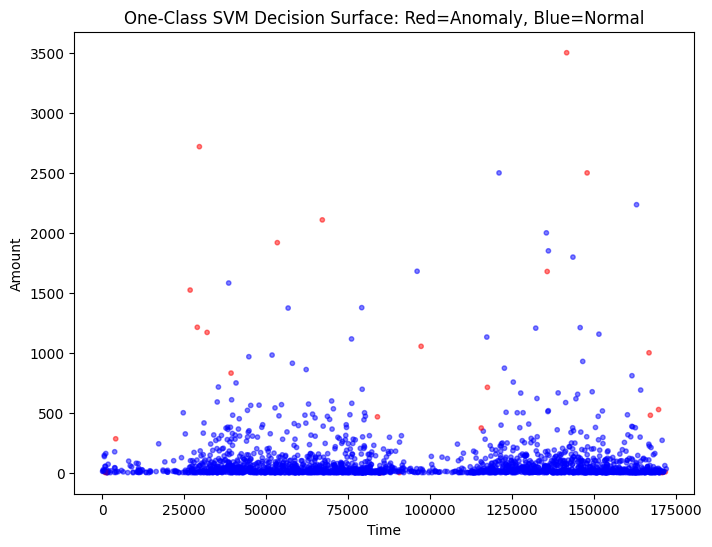

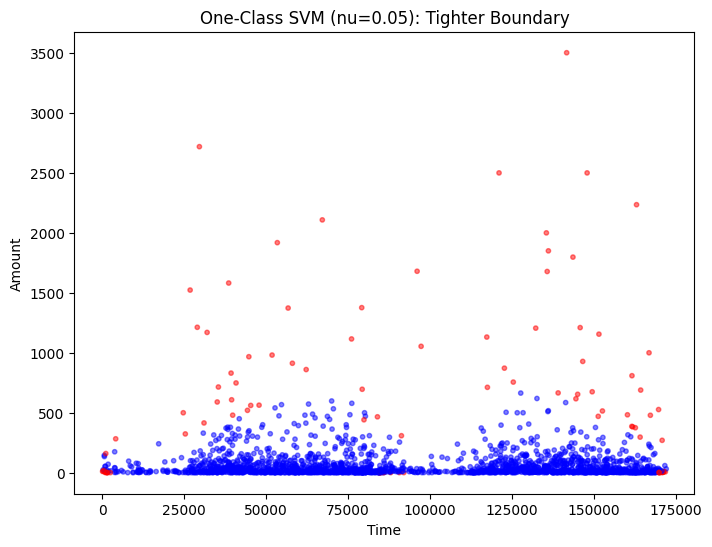

In [5]:
# Visualize decision surface for Amount vs Time (subset for speed)
subset = df.sample(2000, random_state=42)
X_vis = subset[['Time_scaled', 'Amount_scaled']].values
ocsvm_vis = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm_vis.fit(X_vis)
y_vis_pred = ocsvm_vis.predict(X_vis)
 
plt.figure(figsize=(8,6))
plt.scatter(subset['Time'], subset['Amount'], c=np.where(y_vis_pred==-1, 'red', 'blue'), s=10, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('One-Class SVM Decision Surface: Red=Anomaly, Blue=Normal')
plt.show()
 
# Try a tighter boundary (higher nu)
ocsvm_vis_tight = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm_vis_tight.fit(X_vis)
y_vis_pred_tight = ocsvm_vis_tight.predict(X_vis)
plt.figure(figsize=(8,6))
plt.scatter(subset['Time'], subset['Amount'], c=np.where(y_vis_pred_tight==-1, 'red', 'blue'), s=10, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('One-Class SVM (nu=0.05): Tighter Boundary')
plt.show()

## 6. Evaluate Model Performance
Let's evaluate the One-Class SVM's predictions using confusion matrix and classification metrics (precision, recall, F1-score).

Confusion Matrix:
[[281424   2891]
 [    82    410]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9898    0.9947    284315
           1     0.1242    0.8333    0.2162       492

    accuracy                         0.9896    284807
   macro avg     0.5620    0.9116    0.6055    284807
weighted avg     0.9982    0.9896    0.9934    284807



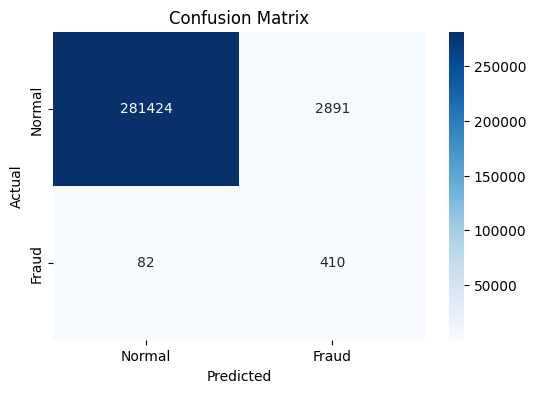

In [6]:
# Confusion matrix and classification report
cm = confusion_matrix(y, df['Anomaly_Pred'])
print("Confusion Matrix:")
print(cm)
 
print("Classification Report:")
print(classification_report(y, df['Anomaly_Pred'], digits=4))
 
# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()